# Introduction to Data Analysis Techniques for Cosmic Microwave Background  Maps

### Jeff McMahon and Renée Hložek 

The Cosmic Microwave Background (CMB) is the oldest observable light in the universe. As such it carries a wealth of cosmological information including: (1) signals from the early universe (primary anisotropy), and (2) distortions imprinted as this light propagates through the universe and encounters collapsed structures (secondary anisotropy).  Measurements of these signals give us important measurements and constraints on inflationary parameters, dark energy, dark matter, the sum of the neutrino masses, and many astrophysical processes.  The development of CMB instruments and analysis techniques is rapidly evolving.

This notebook provides an introduction to analysis techniques for CMB maps as they pertain to high resolution CMB instruments such as the Atacama Cosmology Telescope (ACT) and the South Pole Telescope (SPT).  These state of the art instruments have thousands of detectors (pixels) deployed on 6 and 10 meter telescopes which produce arc minute resolution beams at 150 GHz.  These telescopes observe by scanning across the sky.  The data from each detector are read out at high speed (typically > 50 Hz) to produce 'detector time streams' which are recored along with pointing information and other ancillary data.  Sophisticated codes are used to convert these time streams into maps of the CMB sky.  These maps can have correlated noise that must be accounted for in data analysis.   The mapmaking algorithms are not described here but represent a very interesting big data challenge as they require cleaning time streams by filtering, identifying transient events, and ultimately compressing ~Tb of data down to maps that are typically 100 Mb or less.  

Here are example maps from SPT (top, taken from a phys.org article from April 2, 2012 titled "South Pole Telescope hones in on dark energy, neutrinos") and ACTPol (bottom, taken from the Naess et al. 2014 CMB polarization paper).  Many features are obvious in these maps including: (1) the primary CMB visible as waves in the intensity, (2) active galactic nuclei and other bright astrophysical point sources which manifest as bright dots, (3) clusters of galaxies which show up as darkened point sources, and (4) horizontal stripes (in the SPT map) that are the result of the noise and map filtering.  The ACTPol figure shows multiple maps; the T is temperature, Q and U are polarization, and E and B are also polarization but decomposed into a basis such that the E is the amplitude of the curl-free component, and B is the amplitude of the divergence free component of the polarization vector field.

![](http://cdn.phys.org/newman/gfx/news/hires/2012/newcosmologi.jpg)

![](http://www.classe.cornell.edu/rsrc/Home/NewsAndEvents/CornellExperimentalCosmologyNews20140528/maps_b.png)



While the current instruments (ACTPol and SPTPol) have multiple frequencies and polarization sensitivity, for simplicity we consider only a single frequency (150 GHz) and only temperature.  Adding extra frequency channels or polarization add the cost of slightly more work and would make this presentation more confusing.  Therefore we leave these complications for a future treatment and focus on temperature alone.  This allows us to show the basics of monty carlo analysis of both the angular power spectrum and matched filter techniques for studying Sunyaev-Zeldovich (SZ) effect.

The short course is organized as follows.   We beginning by building simulation of the CMB sky including the primary CMB, point sources (AGN and dusty galaxies), the SZ effect, and (if time) CMB lensing.   To these maps, we fold in instrumental effects including the beam, instrument and atmospheric noise.  We then present several analysis techniques including monty carlo estimation of power spectra and matched filter techniques for extraction of sources    An example of a stacking analysis is presented as an example of a cross-correlation with external data sets.  Cross-correlation is a very active field of research.

In the interest of simplicity we use approximate distributions for source and SZ counts with combinations of exponential and poisson distributions.   We note explicitly where we make these approximations.

## Code preliminaries
We use the following libraries in this code.  All are available through Anaconda.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

## ipython notebook magic word to plot in the notebook
%matplotlib inline

## ipython notebook magic word to change the base directory
#%cd /Your/location/to/the/data

## Section 1.1: Angular Power Spectrum
The majority of the information content of the CMB is contained in its angular power spectrum.   This spectrum is the amplitude squared of the magnitude of the temperature fluctuations as a function of $\ell$.  Here $\ell$ is the variable you have seen before with the spherical harmonics (e.g., $Y_{\ell m}$).  $\ell = 0$ corresponds to a constant temperature across the sky, $\ell = 200$ corresponds approximately to scales of $1^\circ$.  For a given set of input cosmological parameters these spectra can be computed with codes including CMBFAST or the more modern equivalent CAMB.  The spectrum used below was computed with CAMB web interface on NASA's LAMBDA interface.

http://lambda.gsfc.nasa.gov/toolbox/tb_camb_form.cfm

It is fun to play with parameters and see how the spectrum changes. 

The relative locations and amplitudes of the peaks carry a great deal of information.  The location of the first peak at $\ell \sim 200$ provided the first definitive measurement that our universe is flat.  The shape of the spectrum constraints a wide variety of cosmological parameters including dark energy and dark matter.  The fall off at high ell (e.g. $\ell \gtrsim 1000$ is called the damping tail and it provides constrains on the spectral index from inflation.  A wealth of cosmological parameters are constrained by measurements of this spectrum.  

At this point the temperature spectrum is well measured and the open frontiers are polarization and secondary anisotropies that are not included in this spectrum.   We will now build simulated skies including the CMB anisotropy and secondary anisotropies.  After that we will show how to estimate the power spectrum from map data using monte carlo techniques.   This monty carlo approach can be used for interpretation of polarization data and for the interpretation of cross-correlations between CMB and other survey data.

Here is how to read in an plot the CMB temperature spectrum from a CAMB simulation.

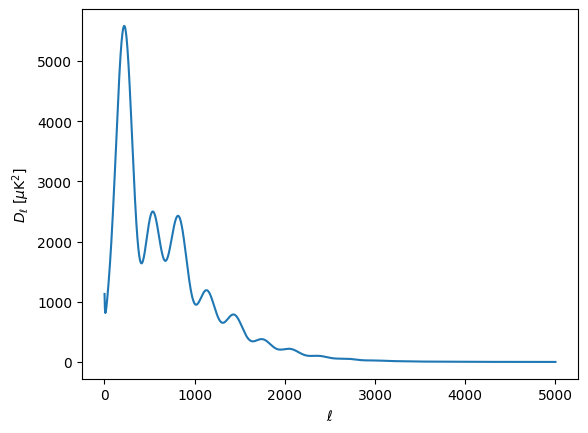

In [2]:
# read in the input CMB spectra
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

This plot is the angular power spectrum of the CMB temperature anisotropies.  It is traditional to plot $D_\ell$ which give the variance on varius angular scales.  This is realted to the angular power spectrum $C_\ell$ by $D_\ell = \frac {\ell (\ell+1)} {2 \pi} C_\ell$.  The correct thing to use for creating CMB maps is $C_\ell$, but $D_\ell$ is what you are used to seeing plotted.

<font color='red'> EXCERCISE: </font>  Go to the NASA LAMBDA CAMB web interface and generate a power spectrum for a for a model universe with a strange component of your choosing (e.g., with spatial curvature, no dark energy, some other bizare component). Make a plot comparing this power spectrum to the vanilla spectram above.  We will compare results 

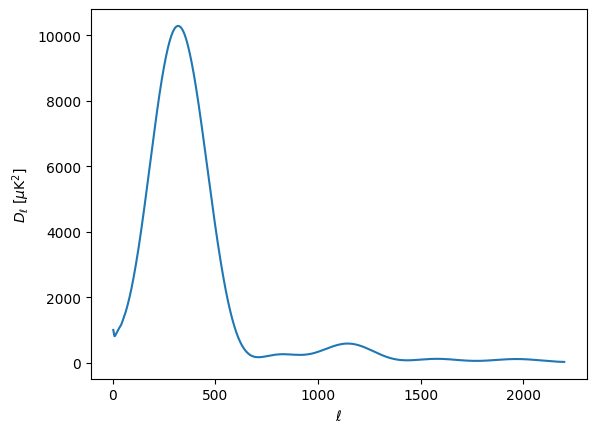

In [3]:
# your code and plots go here
# read in the input CMB spectra
ell, DlTT = np.loadtxt("k_test_camb_high_o_baryon_scalcls.dat", usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Comment on how your spectrum from this strange model universe compars to the spectrum from standard cosmology here.

#### KUSH
I changed the Omega baryon to be ten times larger, which seems to have flattened the power spectra

## Section 1.2: Temperature Anisotropy Map
In this step we generate a simulated map of the CMB sky with the spectrum we read in above.  Since the power spectrum is a function of $\ell$ we need to do much of the work in harmonic space.  If we were generating a map on the full sky we would need to work with spherical harmonics.  Here we consider a small patch of sky ($\sim 10^\circ \times 10^\circ$) were we cam is the 'flat-sky' approximation and replace $\ell$ with $k = \sqrt{k_x^2 + k_y^2}$.  There is a linear dependance between these variables defined by $\ell = k* 2 \pi$.

In the flat sky approximation we generate a CMB map by:  (1) generating a 2D power spectrum by revolving the above spectrum (properly normalized) about the axis in polar coordinates, (2) generating a Gaussian random map with unit variance as our 'random realisation', (3) multiplying that maps from 1 and 2, and (4) Fourier transforming this to get a real space map.  We provide a function to do this and a function to plot this (and other maps) with a uniform color scale.

map mean: 5184997.652527973 map rms: 236305440.7499285


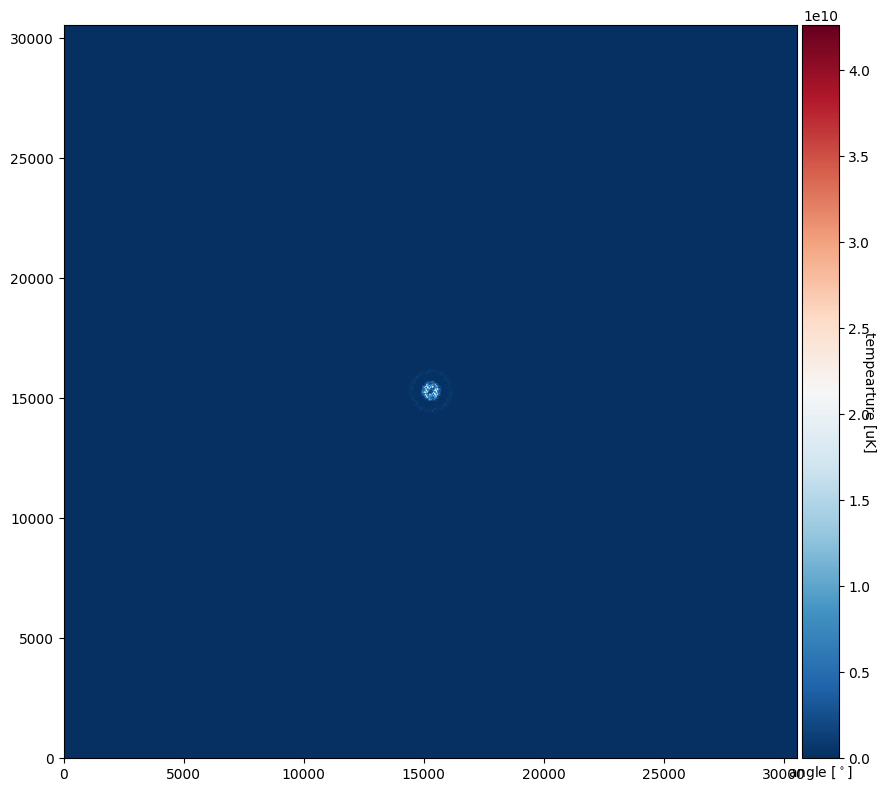

map mean: 1.7364286774045048 map rms: 122.61197805967598


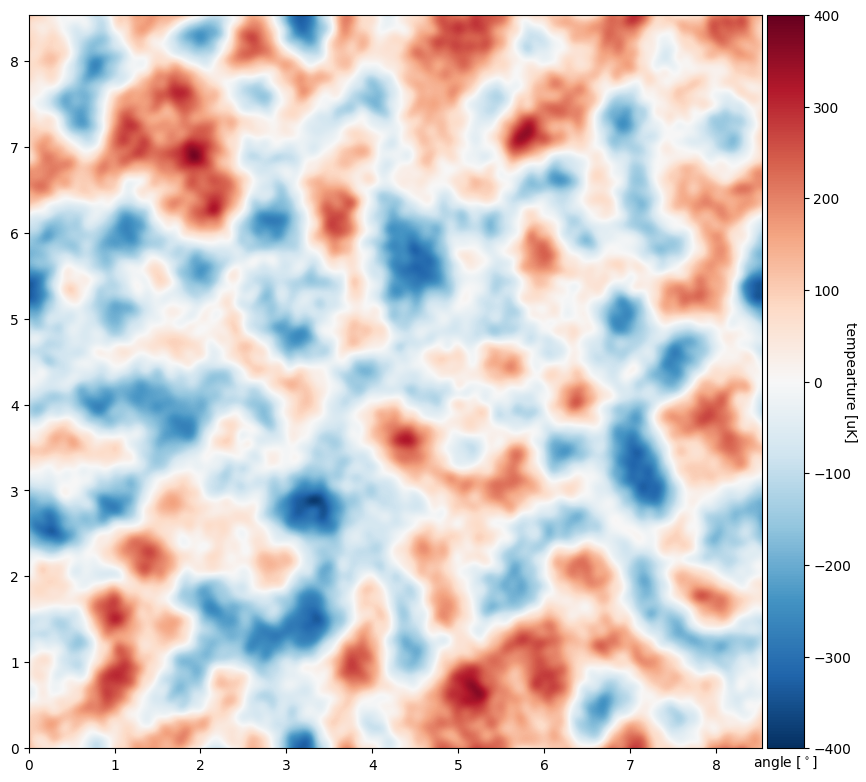

<Figure size 640x480 with 0 Axes>

In [4]:
## variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_CMB_T_map(N,pix_size,ell,DlTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
        
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    plt.imshow(np.real(FT_2d))
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.real(np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi)),ell2d.max(),ell2d.max())  ###
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
    return(0)
  ###############################

## make a CMB T map
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
plt.savefig('cmb1.png')
plt.clf()


This contour plot shows simulated CMB map we just generated.  If you generate it multiple times you will find that you get different patterns, however you will see that the typical size of the brightest and darkest spots will stay around $1^\circ$, corresponding to the peak of the angular power spectrum.  All simulated sky maps are displayed with the same color scale to permit visual comparison.

<font color='red'>EXCERCISE: </font>  Make a function called "make_CMB_T_map_visualize_steps" by copying the code from "make_CMB_T_map" above and changing the function name.  In this version, make a contour plot of (1) the 2D CMB power spectrum and (2) your realization of the spectrum in harmonic space.   Run this multiple times to see how your realization changes at each iteration.

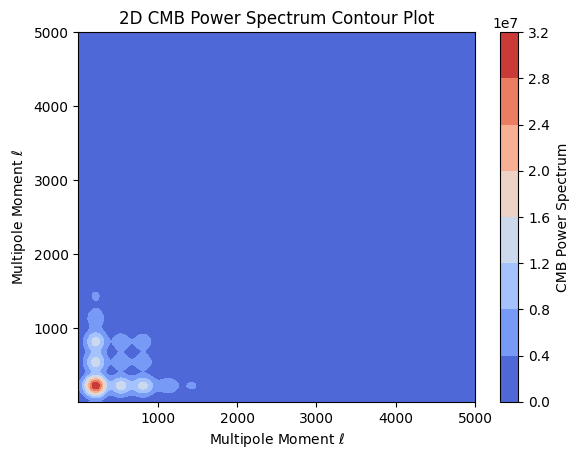

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Generate data
ell, cl = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
# Set up the contour plot
fig, ax = plt.subplots()
cs = ax.contourf(ell, ell, cl.reshape(-1, 1) * cl, cmap='coolwarm')
# Add a colorbar to the plot
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('CMB Power Spectrum')
# Set the axis labels and title
ax.set_xlabel('Multipole Moment $\ell$')
ax.set_ylabel('Multipole Moment $\ell$')
ax.set_title('2D CMB Power Spectrum Contour Plot')
# Show the plot
plt.show()

Discuss: (1)  how the CMB power sepctrum related to the realization, and (2) how the realization in harmonic space relates to the CMB map.

<font color='red'>EXCERCISE: </font>  Re-run your code with the spectrum from your strange model univese.  Compare how the maps look. How does the map produced change if you set the original power spectrum to zero on small scales (eg. $\ell > 1000$)? And if you set all large scales to zero?

In [6]:
## your code goes here

Your comments go here
#### KUSH 
With the strange unierse power spectrum, the map has much higher temperatures at low degrees, and lower temperatures farther out, corresponding to the peak at low $\ell$, then the later damped effect. The graph of the harmonic grows smaller as well, due to the fact that my data goprs to a lower $\ell$ than the original